# Cancer type classifier from TCGA RNAseq gene expression data using fastai deep learning library

In [84]:
"""2018-10-06 Jonathan Irish
   Parts of this notebook are based on the lecture 7 notebook from 
   Jeremy Howard's Practical Deep Learning for Coders 2018 MOOC
   https://github.com/fastai/fastai/blob/master/courses/dl1/lesson7-CAM.ipynb"""

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [81]:
from fastai.imports import *

In [82]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [69]:
import seaborn as sb
sb.set_style("whitegrid", {'axes.grid' : False})

In [70]:
# path to training set and manifest
PATH = "/ssdata/data/tcga/fpkm13class/all/"
sz = 170

In [71]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


### A note about the input data
This notebook uses jpeg image files as input which were generated from TCGA 
(The Cancer Genome Atlas) RNAseq gene expression text files, one per 
TCGA patient barcode, which were downloaded from the TCGA data portal,
then pre-processed to match the TCGA patient barcode with the sample UUID
used by the processing center to name the gene expression files. A manifest
csv file was also created to provide cancer type labels for each
expression-profile-as-image jpeg file. The conversion of gene expression text
files to jpeg files facilitates data loading using the fastai library,
allowing greater time to be spent focusing on building, training, and
evaluating the machine learning model.

### TCGA cancer type codes used in this dataset

    BRCA 	Breast invasive carcinoma
    COAD 	Colon adenocarcinoma
    GBM 	Glioblastoma multiforme
    HNSC 	Head and Neck squamous cell carcinoma
    KIRC 	Kidney renal clear cell carcinoma
    KIRP 	Kidney renal papillary cell carcinoma
    LUAD 	Lung adenocarcinoma
    LUSC 	Lung squamous cell carcinoma
    PRAD 	Prostate adenocarcinoma
    READ 	Rectum adenocarcinoma
    THCA 	Thyroid carcinoma
    UCEC 	Uterine Corpus Endometrial Carcinoma

In [72]:
f_model = dn121 # densenet 121 conv2D architecture

# this notebook is written for python3.6+
label_csv = f'{PATH}alldata_manifest.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [28]:
def get_data(xsz):
    tfms = tfms_from_model(f_model, xsz, aug_tfms=None, max_zoom=None)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name=None, bs=24)

In [10]:
data = get_data(sz)

In [11]:
i = iter(data.val_dl)
x, y = next(i)
x2, y2 = next(i)
x3, y3 = next(i)

In [13]:
v0 = data.val_ds.denorm(x3)

In [14]:
# confirm tensor is expected shape
v0.shape

(64, 170, 170, 3)

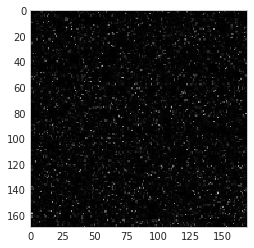

In [15]:
plt.imshow(v0[9])

In [17]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

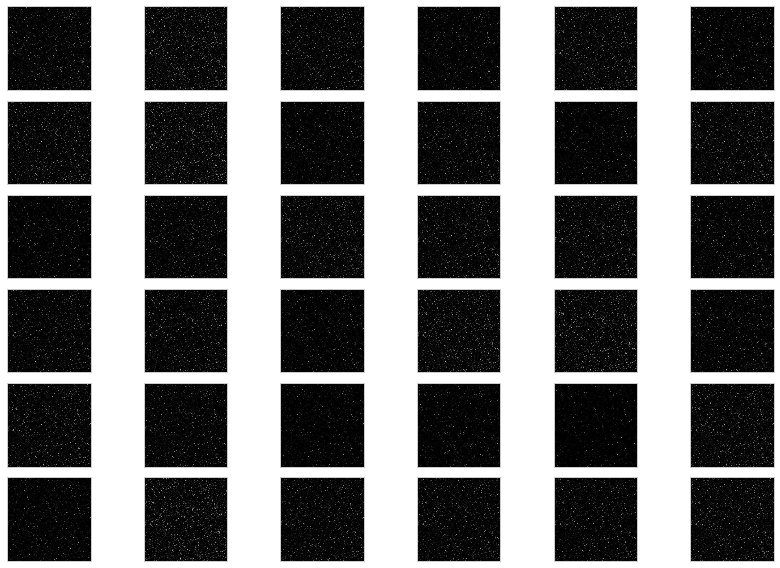

In [18]:
fig, axes = plt.subplots(6, 6, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima= data.val_ds.denorm(x3)[i]
    #b = data.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    #draw_text(ax, (0,0), b)
plt.tight_layout()

In [19]:
learn = ConvLearner.pretrained(f_model, data)

In [55]:
%time lrf = learn.lr_find()

 94%|█████████▍| 51/54 [00:15<00:00,  3.26it/s, loss=15]  CPU times: user 23.8 s, sys: 7.08 s, total: 30.9 s
Wall time: 15.7 s


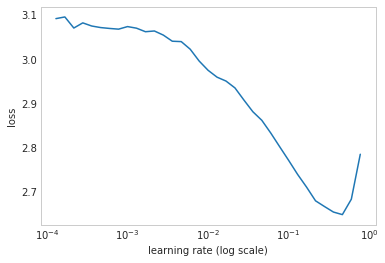

In [56]:
learn.sched.plot()

In [57]:
lr = 1e-1

In [51]:
%time learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      2.111908   1.407092   0.554259  
    1      1.905614   1.390383   0.555426  
    2      1.557424   1.075451   0.645274  
    3      1.50188    1.153181   0.603267  
    4      1.325673   0.965403   0.693116  
    5      1.17968    0.90046    0.705951  
    6      1.095376   0.888769   0.705951  
    7      1.118293   0.933328   0.694282  
    8      1.147789   0.885901   0.709452  
    9      1.104131   0.859452   0.709452  
    10     1.048077   0.829574   0.733956  
    11     0.973034   0.774005   0.751459  
    12     0.945171   0.746249   0.756126  
    13     0.901951   0.736925   0.75846   
    14     0.892362   0.735842   0.756126  
CPU times: user 6min 46s, sys: 1min 40s, total: 8min 27s
Wall time: 3min 44s


[array([0.73584]), 0.7561260205861985]

In [18]:
learn.save('rn270_0p1LR')

/home/irish/py36torch03/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


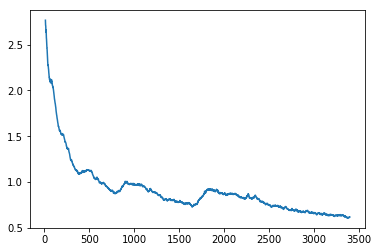

/home/irish/py36torch03/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [19]:
learn.sched.plot_loss()

In [20]:
learn.fit(lr, 2, cycle_len=10, cycle_mult=2)

 17%|█▋        | 9/54 [00:02<00:12,  3.66it/s, loss=0.629]

/home/irish/py36torch03/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


epoch      trn_loss   val_loss   accuracy                  
    0      0.686021   0.71006    0.767795  
    1      0.754348   0.691893   0.774796                  
    2      0.809516   0.700817   0.765461                  
    3      0.75367    0.670857   0.784131                  
    4      0.736937   0.69774    0.781797                  
    5      0.718372   0.646046   0.800467                  
    6      0.676042   0.645111   0.792299                  
    7      0.690965   0.628201   0.803967                  
    8      0.659671   0.63028    0.801634                  
    9      0.656154   0.629073   0.8028                    
    10     0.746688   0.740905   0.750292                  
    11     0.781306   0.702237   0.775963                  
    12     0.787573   0.704223   0.774796                  
    13     0.799593   0.746011   0.750292                  
    14     0.804473   0.718588   0.765461                  
    15     0.773119   0.711092   0.778296               

[array([0.60919]), 0.7969661612354888]

In [21]:
learn.save('rn270_0p1LR_frozen')

In [20]:
# unfreeze all layers in pre-trained model
learn.unfreeze()

In [22]:
lr = 1.0e-1
# fastai library implements multiple learning rates for different layer groups
lrs = [lr/100.0, lr/10.0, lr]

In [26]:
learn.fit(lrs, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.281356   0.297014   0.900817  
    1      0.285495   0.329789   0.87748   
    2      0.217206   0.284829   0.896149  
    3      0.234834   0.380771   0.882147  
    4      0.262795   0.43698    0.865811  
    5      0.199075   0.300798   0.903151  
    6      0.150277   0.284637   0.904317  
    7      0.231994   0.586288   0.864644  
    8      0.222774   0.354954   0.884481  
    9      0.158987   0.343054   0.906651  
    10     0.128141   0.306312   0.892649  
    11     0.089437   0.287577   0.910152  
    12     0.070342   0.295762   0.906651  
    13     0.059652   0.277973   0.911319  
    14     0.048353   0.281468   0.912485  



[array([0.28147]), 0.9124854147225584]

In [27]:
learn.save('dn121_sz180_unfreeze2')

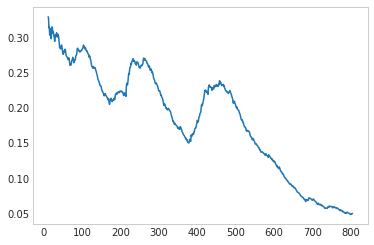

In [32]:
learn.sched.plot_loss()

In [33]:
log_preds, y = learn.TTA()

In [34]:
probs = np.mean(np.exp(log_preds),0)

In [35]:
# Confusion matrix to visualize results
preds = np.argmax(probs, axis=1)
#probs = probs[:,1]

In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
cm = confusion_matrix(y, preds)

[[165   0   0   1   0   0   0   0   0   1   0   0   0]
 [  1  49   0   0   1   0   0   1   1   0   9   0   1]
 [  0   0  16   0   0   0   2   0   0   0   0   0   0]
 [  1   0   0  72   0   0   0   0   9   0   0   0   0]
 [  0   0   0   0  74   6   0   0   2   0   0   0   0]
 [  0   0   0   0   2  28   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0  69   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0  69   6   0   0   0   0]
 [  0   0   0   3   0   0   1   2  43   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  67   0   0   0]
 [  0  16   0   0   0   0   0   0   0   0   5   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0  51   0]
 [  1   1   1   1   0   0   0   1   0   0   0   0  74]]


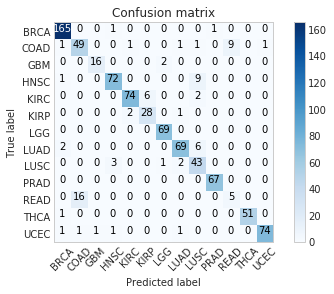

In [38]:
plot_confusion_matrix(cm, data.classes)

In [43]:
data2 = get_data(220) # increase image size (NOTE: get_data updated to decrease batch sz down to 24 images)

In [39]:
lrs2 = [lr/1000.0, lr/10.0, lr] # decrease earliest learning rate
learn2 = ConvLearner.pretrained(f_model, data2)
learn2.load('dn121_sz180_unfreeze2')

In [40]:
learn2.unfreeze()

In [41]:
learn2.fit(lrs, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.650802   0.395378   0.863477  
    1      0.437805   0.330962   0.875146  
    2      0.320486   0.281225   0.892649  
    3      0.275055   0.296718   0.890315  
    4      0.232673   0.264609   0.89965   



[array([0.26461]), 0.8996499401268353]

epoch      trn_loss   val_loss   accuracy   
    0      0.211582   0.27399    0.901984  
    1      0.215847   0.345559   0.897316  
    2      0.137664   0.313262   0.900817  
    3      0.250905   0.354154   0.892649  
    4      0.196508   0.321878   0.870478  
    5      0.11844    0.277344   0.913652  
    6      0.065138   0.261136   0.913652  
    7      0.16805    0.370322   0.906651  
    8      0.181871   0.529983   0.85881   
    9      0.135373   0.415968   0.863477  
    10     0.092832   0.432639   0.892649  
    11     0.055229   0.325716   0.907818  
    12     0.032053   0.327994   0.904317  
    13     0.027991   0.33233    0.906651  
    14     0.017805   0.316342   0.910152  
    15     0.113006   0.423892   0.897316  
    16     0.083911   0.471232   0.889148  
    17     0.113803   0.47482    0.891482  
    18     0.07758    0.494123   0.887981  
    19     0.074792   0.406363   0.911319  
    20     0.062876   0.442952   0.908985  
    21     0.059004   0.371859 

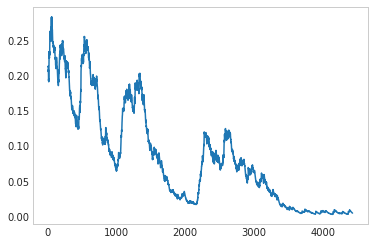

In [44]:
learn2.fit(lrs, 5, cycle_len=1, cycle_mult=2)
learn2.sched.plot_loss()

In [ ]:
learn2.save('dn121_sz220_unfreeze1')

In [166]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p))) # first log term drops if y == 0,
                                                         #second drops if y == 1 (like an "if/else" statement)

In [132]:
learn.fit(0.1, 4, cycle_len=3, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.633938   0.541993   0.823804  
    1      0.628464   0.532371   0.814469                  
    2      0.58445    0.511975   0.820303                  
    3      0.623139   0.569298   0.795799                  
 85%|████████▌ | 46/54 [00:01<00:00, 29.25it/s, loss=0.658]

/home/irish/py36torch03/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


    4      0.644602   0.579553   0.795799                  
    5      0.628654   0.522446   0.824971                  
    6      0.588332   0.526099   0.834306                  
    7      0.57529    0.515506   0.831972                  
    8      0.575472   0.513082   0.828471                  
    9      0.605179   0.519751   0.822637                  
    10     0.634088   0.558299   0.808635                  
    11     0.654501   0.558798   0.812135                  
    12     0.657557   0.606359   0.791132                  
    13     0.642312   0.506028   0.836639                  
    14     0.612043   0.542548   0.8028                    
    15     0.600615   0.535893   0.815636                  
    16     0.572795   0.507226   0.82147                   
    17     0.556611   0.501785   0.829638                  
    18     0.539914   0.484757   0.836639                  
    19     0.520579   0.488439   0.831972                  
    20     0.530426   0.490556   0.83547

[array([0.45208]), 0.8518086340074082]

In [133]:
learn.save('rn34_sz90_lr0p1_frzn')

In [45]:
log_preds, y = learn2.TTA()
probs = np.mean(np.exp(log_preds),0)
preds = np.argmax(probs, axis=1)
#probs = probs[:,1]
cm = confusion_matrix(y, preds)

[[166   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0  54   0   0   1   0   0   0   1   0   7   0   0]
 [  0   0  16   0   0   0   2   0   0   0   0   0   0]
 [  1   0   0  72   0   0   0   0   9   0   0   0   0]
 [  0   0   0   1  78   3   0   0   0   0   0   0   0]
 [  0   0   0   0   2  28   0   0   1   0   0   0   0]
 [  0   0   1   0   0   0  68   0   0   0   0   0   0]
 [  1   1   0   0   0   0   0  67   8   0   0   0   0]
 [  0   0   0   4   0   0   0   3  41   1   0   0   0]
 [  0   0   0   0   0   1   0   0   0  66   0   0   0]
 [  0  17   0   0   0   0   0   0   0   0   4   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0  51   0]
 [  0   0   0   1   0   0   0   1   0   0   0   0  77]]


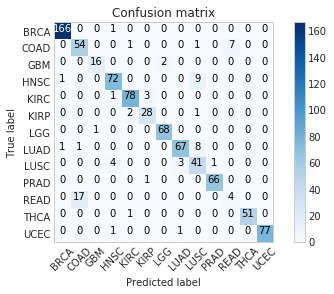

In [46]:
plot_confusion_matrix(cm, data.classes)

### NOTES: 
- overall classification accuracy of ~90% was achieved, however the model is still overfitting.
- the model consistently classifies READ samples as COAD, but not the converse; as these are both GI cancers, is there interesting biology behind this?
- while the model confused READ samples with COAD, there are other pairs of cancer types with similar anatomic origin which are not confused. Why?

In [35]:
learn.save('rn34_sz279_lr0p1_unfrz')

## CAM - Class Activation Mapping

### Objective

Neural network learning models are often criticized as "black box" models which are impervious to interpretation.
Class Activation Mapping is an interpretation method which plots a heatmap over the input image, with the greatest
intensity corresponding with the pixels in the input image which most strongly contributed to activations which
resulted in classification of the input image. In actual images, this should result in the part of the image with
the actual object corresponding to the class label under the hottest parts of the heatmap, and ideally no other
part of the image will be "hot". For the purposes of this dataset, my intention is to eventually rank the pixels
with the highest CAM values and look up the genes represented by the pixels with the highest CAM values, some of
which I hypothesize will be genes known to be associated with that cancer type. If this hypothesis is confirmed
by the data, a follow-on hypothesis is that there may be value in investigating the genes with high 
class predictive value which are not currently known to be driving oncogenes in a given cancer type.

In [2]:
def get_dataCAM(xsz):
    tfms = tfms_from_model(resnet34, xsz, aug_tfms=None, max_zoom=None)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name=None)

In [9]:
PATH = "/ssdata/data/tcga/fpkm13class/all/"
label_csv = f'{PATH}alldata_manifest.csv'
f_model = dn121
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)
dataCAM = get_dataCAM(220)

In [10]:
# Try Class Activation Mapping (CAM) to identify genes contributing the most to a classification
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [11]:
# Try making model with new head from rn34 model
# pre-trained on our dataset (TCGA fpkm13class)
#dataCAM = get_dataCAM(180)
learn34 = ConvLearner.pretrained(resnet34, dataCAM)
learn34.load('rn34_sz279_lr0p1_unfrz')

In [12]:
m0 = learn34.models.model

# use a different "head" with Conv2d as final layer before pooling and Softmax
# number of Conv2d filters matches number of classes (13 in this case)
m = nn.Sequential(*children(m0)[:-12],
                  nn.Conv2d(128, 13, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [13]:
learn_custHead = ConvLearner.from_model_data(m, dataCAM)

In [14]:
learn_custHead.fit(1e-2, 2, cycle_len=8)

epoch      trn_loss   val_loss   accuracy   
    0      2.551197   2.484382   0.091015  
    1      2.441634   2.365918   0.213536  
    2      2.385016   2.343028   0.224037  
    3      2.346566   2.299824   0.221704  
    4      2.298766   2.242793   0.252042  
    5      2.239073   2.181238   0.290548  
    6      2.174613   2.120753   0.323221  
    7      2.138395   2.113495   0.323221  
    8      1.977039   1.765817   0.352392  
    9      1.610272   1.421363   0.445741  
    10     1.268681   1.266463   0.537923  
    11     1.014307   0.986295   0.63944   
    12     0.784834   0.82248    0.732789  
    13     0.636706   0.650089   0.787631  
    14     0.549171   0.548828   0.850642  
    15     0.503053   0.535292   0.850642  



[array([0.53529]), 0.850641773002985]

In [15]:
learn_custHead.unfreeze()

In [19]:
sf = SaveFeatures(m[-4])

In [16]:
lr3 = 1e-2
learn_custHead.fit(lr3, 2, cycle_len=3)

epoch      trn_loss   val_loss   accuracy   
    0      0.505235   1.32372    0.555426  
    1      0.42452    0.73725    0.751459  
    2      0.357097   0.398221   0.891482  
    3      0.362083   1.283804   0.577596  
    4      0.299328   0.418393   0.868145  
    5      0.245596   0.319455   0.904317  



[array([0.31946]), 0.9043173862310385]

In [24]:
learn_custHead.fit(1e-4, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.203034   0.314725   0.907818  



[array([0.31473]), 0.9078179696616102]

In [25]:
learn_custHead.save(f'rn34_CAMlrnr_unfrz_2')

In [22]:
x1, y1 = next(iter(dataCAM.val_dl))

In [23]:
x,y = x1[None,1], y1[None,1]
vx = Variable(x.cuda(), requires_grad=True)

In [24]:
x.shape

torch.Size([1, 3, 180, 180])

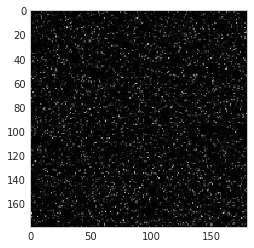

In [25]:
dx = dataCAM.val_ds.denorm(x1)[3]
plt.imshow(dx);

In [91]:
# NOTE: SaveFeatures is called on the trained model, and then populated with values from
#       the forward pass with the data from the dataloader
def plotCAM(mdl, data, idx, batchix):
    i = iter(data.val_dl)
    # burn a few iterations
    for f in range(batchix + 1):
        x1, y1 = next(i)
    classes = data.classes
    sf = SaveFeatures(mdl[-4]) # NEW
    py = mdl(Variable(x1.cuda()))
    sf.remove() # NEW
    y = np.exp(to_np(py)[idx])
    featmat = np.maximum(0,to_np(sf.features[idx]))
    f2 = np.dot(np.rollaxis(featmat,0,3), y)
    f2 -= f2.min()
    f2 /= f2.max()
    
    dx = data.val_ds.denorm(x1)[idx]
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(dx)
    ax.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.4, cmap='jet')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(classes[data.val_y[idx + (batchix * 64)]], fontsize=18, fontweight='bold')
    
# alias final plotCAM definition to previous names used during development
plotCAMtest = plotCAM
plotCAM2 = plotCAM


# return dot-product matrics of saved_features with input
# TODO: get elements above a specified threshold, then use position of element
#       in original image as index into gene list to get gene IDs of expression
#       pixels most definitive in classifying cancer type
def getCAMmatrix(mdl, data, idx, batchidx):
    i = iter(data.val_dl)
    # burn a few iterations
    for f in range(batchidx + 1):
        x1, y1 = next(i)
    classes = data.classes
    sf = SaveFeatures(mdl[-4]) # NEW
    py = mdl(Variable(x1.cuda()))
    sf.remove() # NEW
    y = np.exp(to_np(py)[idx])
    featmat = np.maximum(0,to_np(sf.features[idx]))
    f2 = np.dot(np.rollaxis(featmat,0,3), y)
    f2 -= f2.min()
    f2 /= f2.max()
    
    dx = data.val_ds.denorm(x1)[idx]
    
    return scipy.misc.imresize(f2, dx.shape)

In [78]:
def plotCAMbatch(mdl, data, batchidx):
    itr = iter(data.val_dl)
    # is there a more idiomatic way to index into a generator?
    for j in range(batchidx + 1):
        x1, y1 = next(itr)
    classes = data.classes
    saved_feats = SaveFeatures(mdl[-4])
    gpu_log_y = mdl(Variable(x1.cuda()))
    saved_feats.remove()
    

    fig, axs = plt.subplots(8, 8, figsize=(12,12))
    for i, ax in enumerate(axs.flat):
        pred_y = np.exp(to_np(gpu_log_y)[i])
        feature_matrix = np.maximum(0, to_np(saved_feats.features[i]))
        f2 = np.dot(np.rollaxis(feature_matrix, 0, 3), pred_y)
        f2 -= f2.min()
        f2 /= f2.max()
        denormed_x = data.val_ds.denorm(x1)[i]
        ax.imshow(denormed_x)
        ax.imshow(scipy.misc.imresize(f2, denormed_x.shape), alpha=0.4, cmap='jet')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(classes[data.val_y[i + (batchidx * 64)]], fontsize=18, fontweight='bold')
    plt.tight_layout()

/home/irish/py36torch03/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


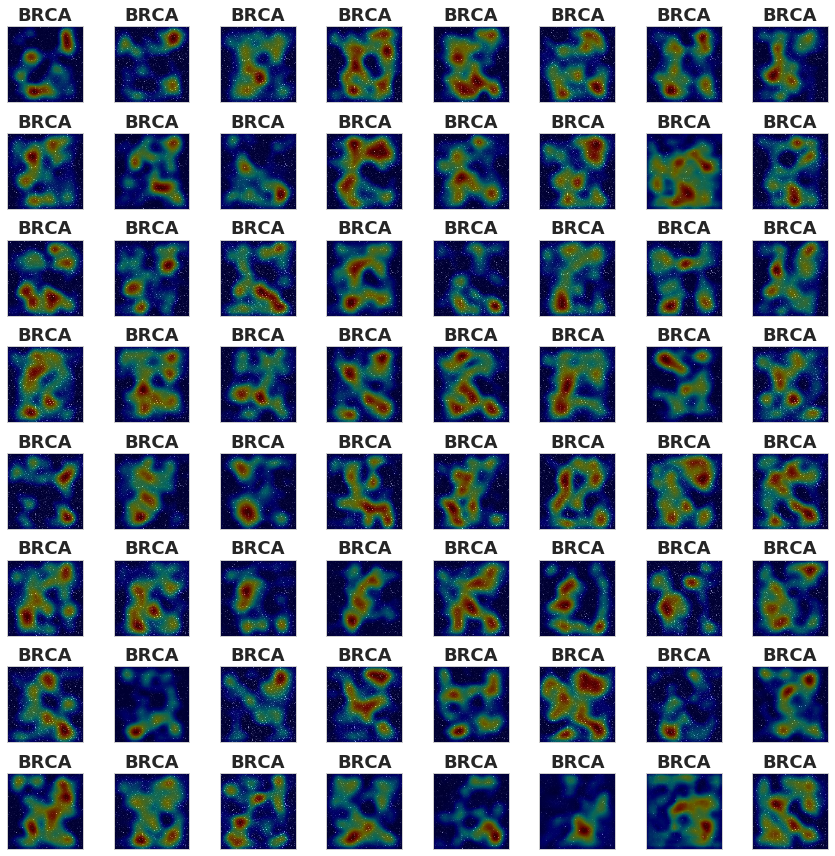

In [79]:
plotCAMbatch(m, dataCAM, 1)

/home/irish/py36torch03/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


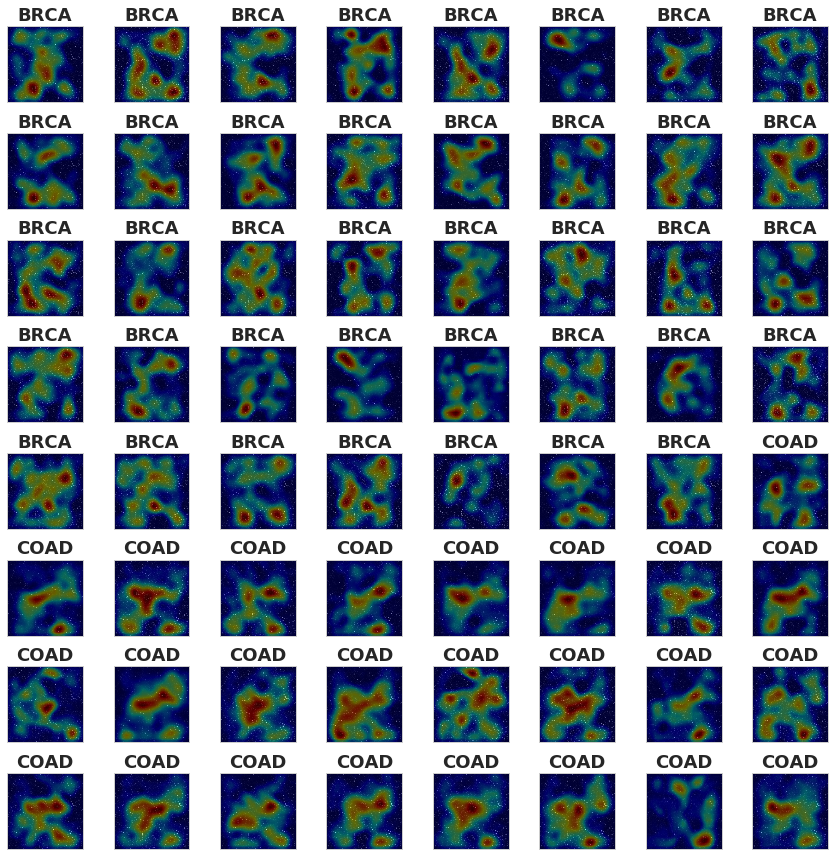

In [80]:
plotCAMbatch(m, dataCAM, 2)

/home/irish/py36torch03/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


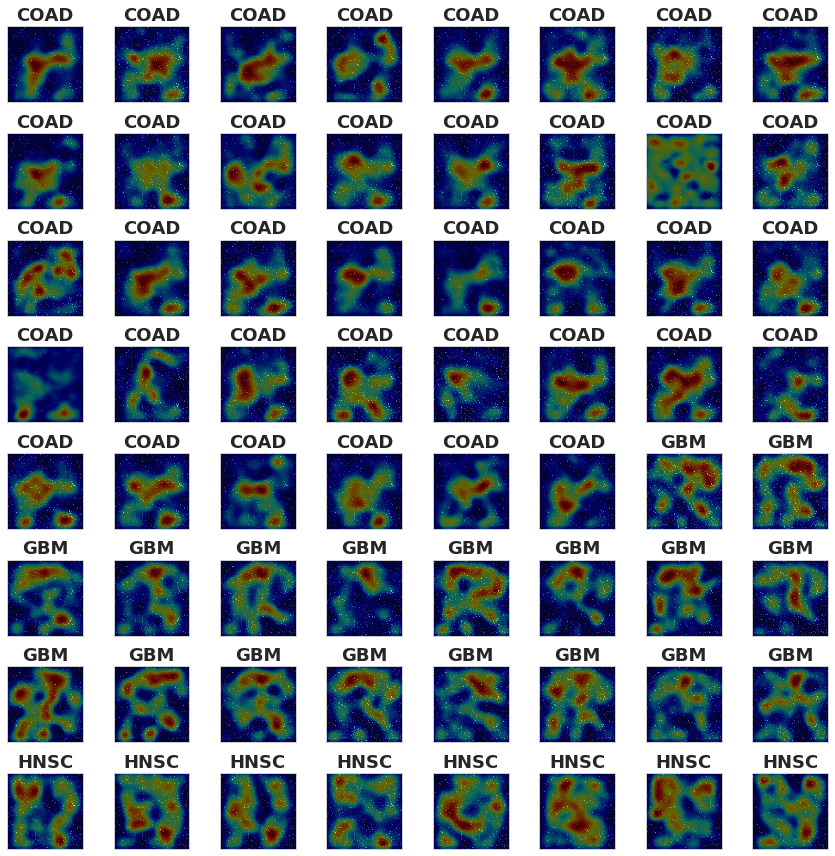

In [81]:
plotCAMbatch(m, dataCAM, 3)

/home/irish/py36torch03/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


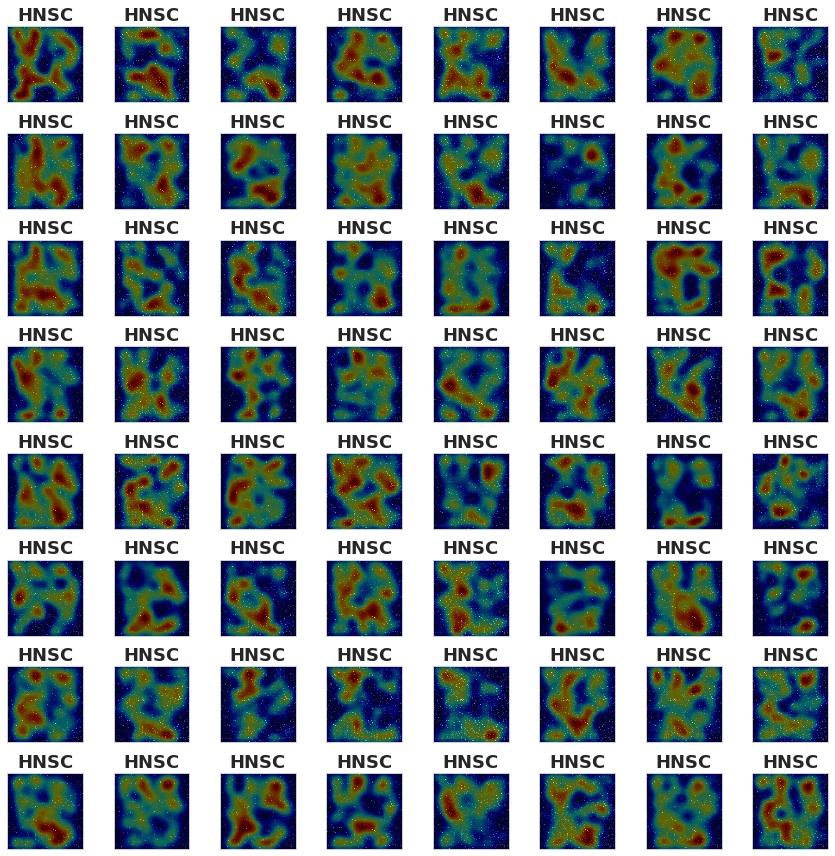

In [82]:
plotCAMbatch(m, dataCAM, 4)

/home/irish/py36torch03/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


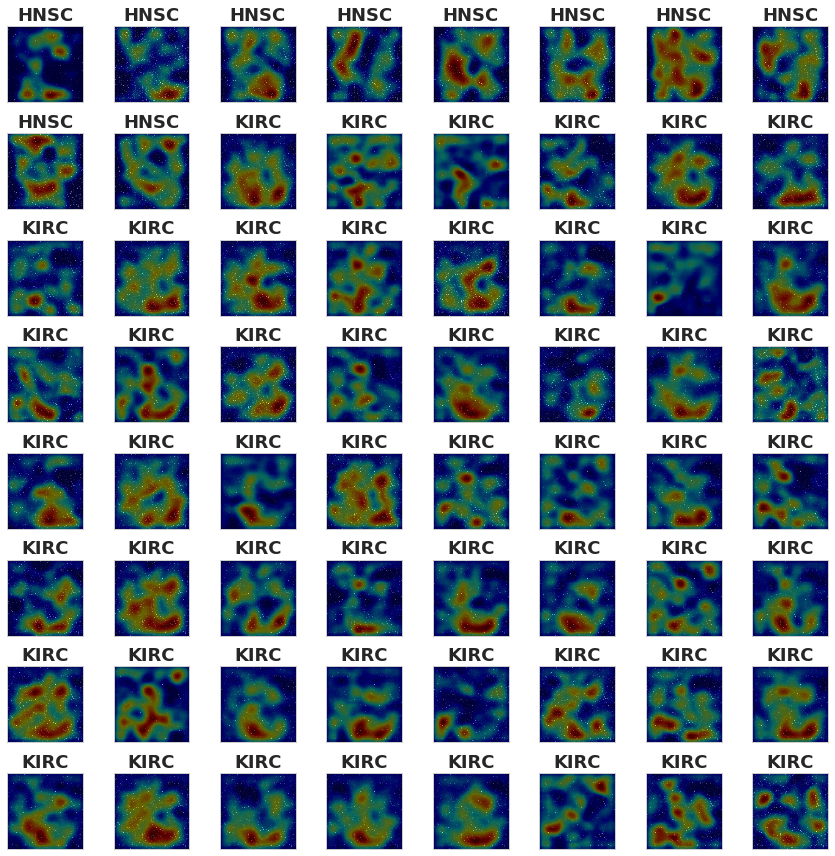

In [83]:
plotCAMbatch(m, dataCAM, 5)

/home/irish/py36torch03/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


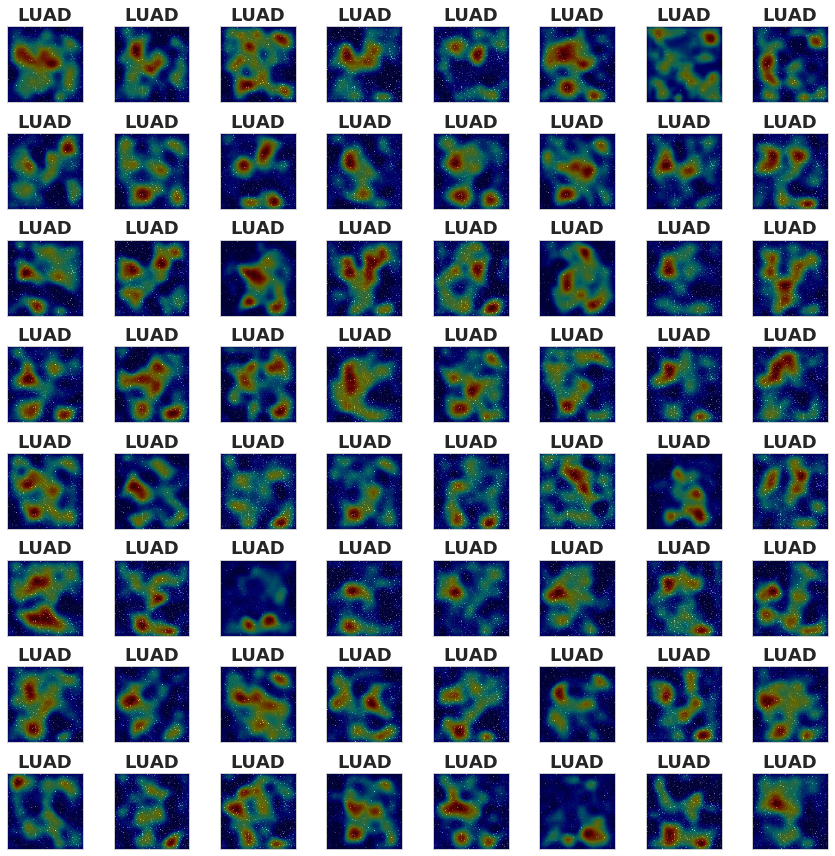

In [84]:
plotCAMbatch(m, dataCAM, 8)

/home/irish/py36torch03/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


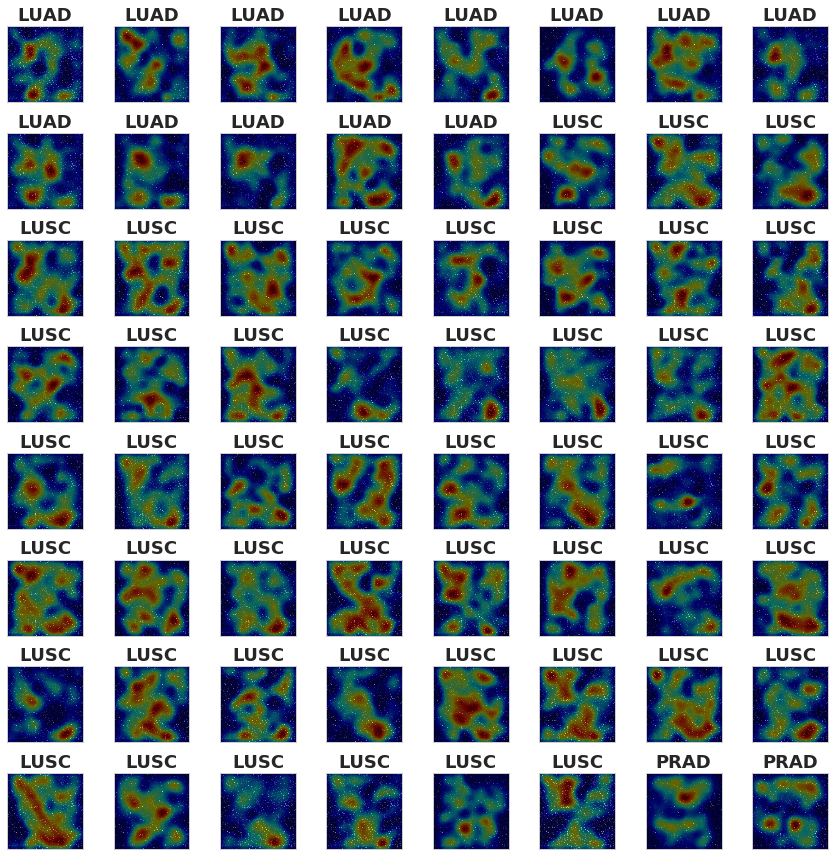

In [86]:
plotCAMbatch(m, dataCAM, 9)